In [42]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import cv2
import gc
from tqdm.notebook import tqdm
from datetime import datetime
from typing import Optional
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from tensorflow import keras
import tensorflow as tf
import keras
from keras.models import load_model, save_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from sklearn.model_selection import train_test_split
import pickle

os.environ['PYTHONHASHSEED'] = '0' 
np.random.seed(70) 
tf.random.set_seed(70)

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

BATCH_SIZE = 16
EPOCHS=10
TRAIN_ROOT_DIR = '/content/drive/MyDrive/DL_Project/uw-madison-gi-tract-image-segmentation/'

In [2]:
train_df_og = pd.read_csv(TRAIN_ROOT_DIR + 'train.csv')

In [3]:
print(train_df_og.shape)
train_df_og.head(10)

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN
6,case123_day20_slice_0003,large_bowel,NaN
7,case123_day20_slice_0003,small_bowel,NaN
8,case123_day20_slice_0003,stomach,NaN
9,case123_day20_slice_0004,large_bowel,NaN


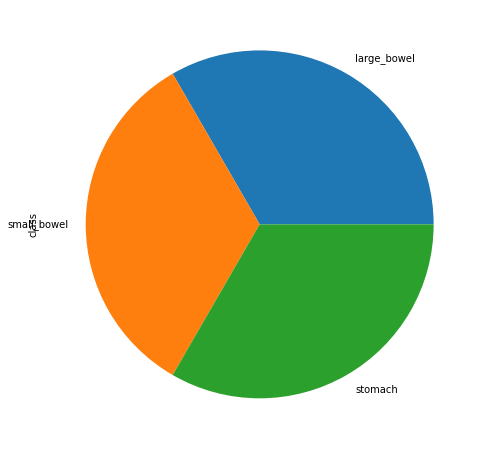

In [ ]:
plt.figure(figsize=(15,8))
train_df_og['class'].value_counts(normalize=True).plot.pie()

In [ ]:
test_df = pd.read_csv(TRAIN_ROOT_DIR+"sample_submission.csv")
test_df.head()

,id,class,predicted


In [ ]:
def dataframe_prep(df,subset='train',DEBUG=False):
  df['case'] = df['id'].apply(lambda x: x.split("_")[0].replace("case",""))
  df['day'] = df['id'].apply(lambda x: x.split("_")[1].replace("day",""))
  df['slice'] = df['id'].apply(lambda x: x.split("_")[3])

  if(subset=='train') or (DEBUG==True):
    DIR = TRAIN_ROOT_DIR + 'train'

  allimages = glob(os.path.join(DIR,"**","*.png"), recursive=True)
  x = allimages[0].rsplit("/",4)[0]

  path_partial_list = []
  for i in range(df.shape[0]):
    path_partial_list.append(os.path.join(x,
                                          'case'+str(df['case'].values[i]),
                                          'case'+str(df['case'].values[i] + '_' + 'day' + str(df['day'].values[i])),
                                          'scans',
                                          'slice_'+str(df['slice'].values[i])))
  df['path_partial'] = path_partial_list

  #path column with path of all images 
  path_partial_list=[]
  for i in range(len(allimages)):
    path_partial_list.append(str(allimages[i].rsplit('_',4)[0]))

  temp_df = pd.DataFrame(columns = ['path_partial','path'])
  temp_df['path_partial'] = path_partial_list
  temp_df['path'] = allimages

  df=df.merge(temp_df, on='path_partial').drop(columns = ['path_partial'])
  df['width'] = df['path'].apply(lambda x: int(x[:-4].rsplit('_',4)[1]))
  df['height'] = df['path'].apply(lambda x: int(x[:-4].rsplit('_',4)[2]))

  del x, path_partial_list, temp_df

  return df

In [ ]:
train_df = dataframe_prep(train_df_og, subset="train")

In [ ]:
train_df.head()

In [ ]:
test_df = dataframe_prep(test_df, subset='test', DEBUG = True)

In [ ]:
def rearrange_df(df, subset='train'):
  df_restruc = pd.DataFrame({id: df['id'][::3]})

  if(subset=='train'):
    df_restruc['large_bowel'] = df['segmentation'][::3].values
    df_restruc['small_bowel'] = df['segmentation'][1::3].values
    df_restruc['stomach'] = df['segmentation'][2::3].values

  df_restruc['path'] = df['path'][::3].values
  df_restruc['case'] = df['case'][::3].values
  df_restruc['day'] = df['day'][::3].values
  df_restruc['slice'] = df['slice'][::3].values
  df_restruc['width'] = df['width'][::3].values  
  df_restruc['height'] = df['height'][::3].values

  df_restruc.reset_index(drop = True, inplace = True)
  df_restruc = df_restruc.fillna('')

  if(subset == 'train'):
    df_restruc['count'] = np.sum(df_restruc.iloc[:, 1:4] != '', axis=1).values
  
  return df_restruc

In [ ]:
train_df_restruc = rearrange_df(train_df, subset='train')
train_df_restruc.head(5)

,<built-in function id>,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,0005,266,266,0


Remove misslabeled training data

In [ ]:
train_df_restruc = train_df_restruc[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)

train_df_restruc = train_df_restruc[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

train_df_restruc = train_df_restruc[(train_df['case']!=138)|(train_df['day']!=00)].reset_index(drop=True)

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/DL_Project/uw-madison-gi-tract-image-segmentation/rearranged_train_df.csv')
train_df.head()

,Unnamed: 0,ID,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,0,case123_day20_slice_0001,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,1,266,266,0
1,1,case123_day20_slice_0002,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,2,266,266,0
2,2,case123_day20_slice_0003,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,3,266,266,0
3,3,case123_day20_slice_0004,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,4,266,266,0
4,4,case123_day20_slice_0005,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,123,20,5,266,266,0


RLE Encoding and Decoding

In [8]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    mask_rle = str(mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

Visulaizing of MRIs with/without tumor

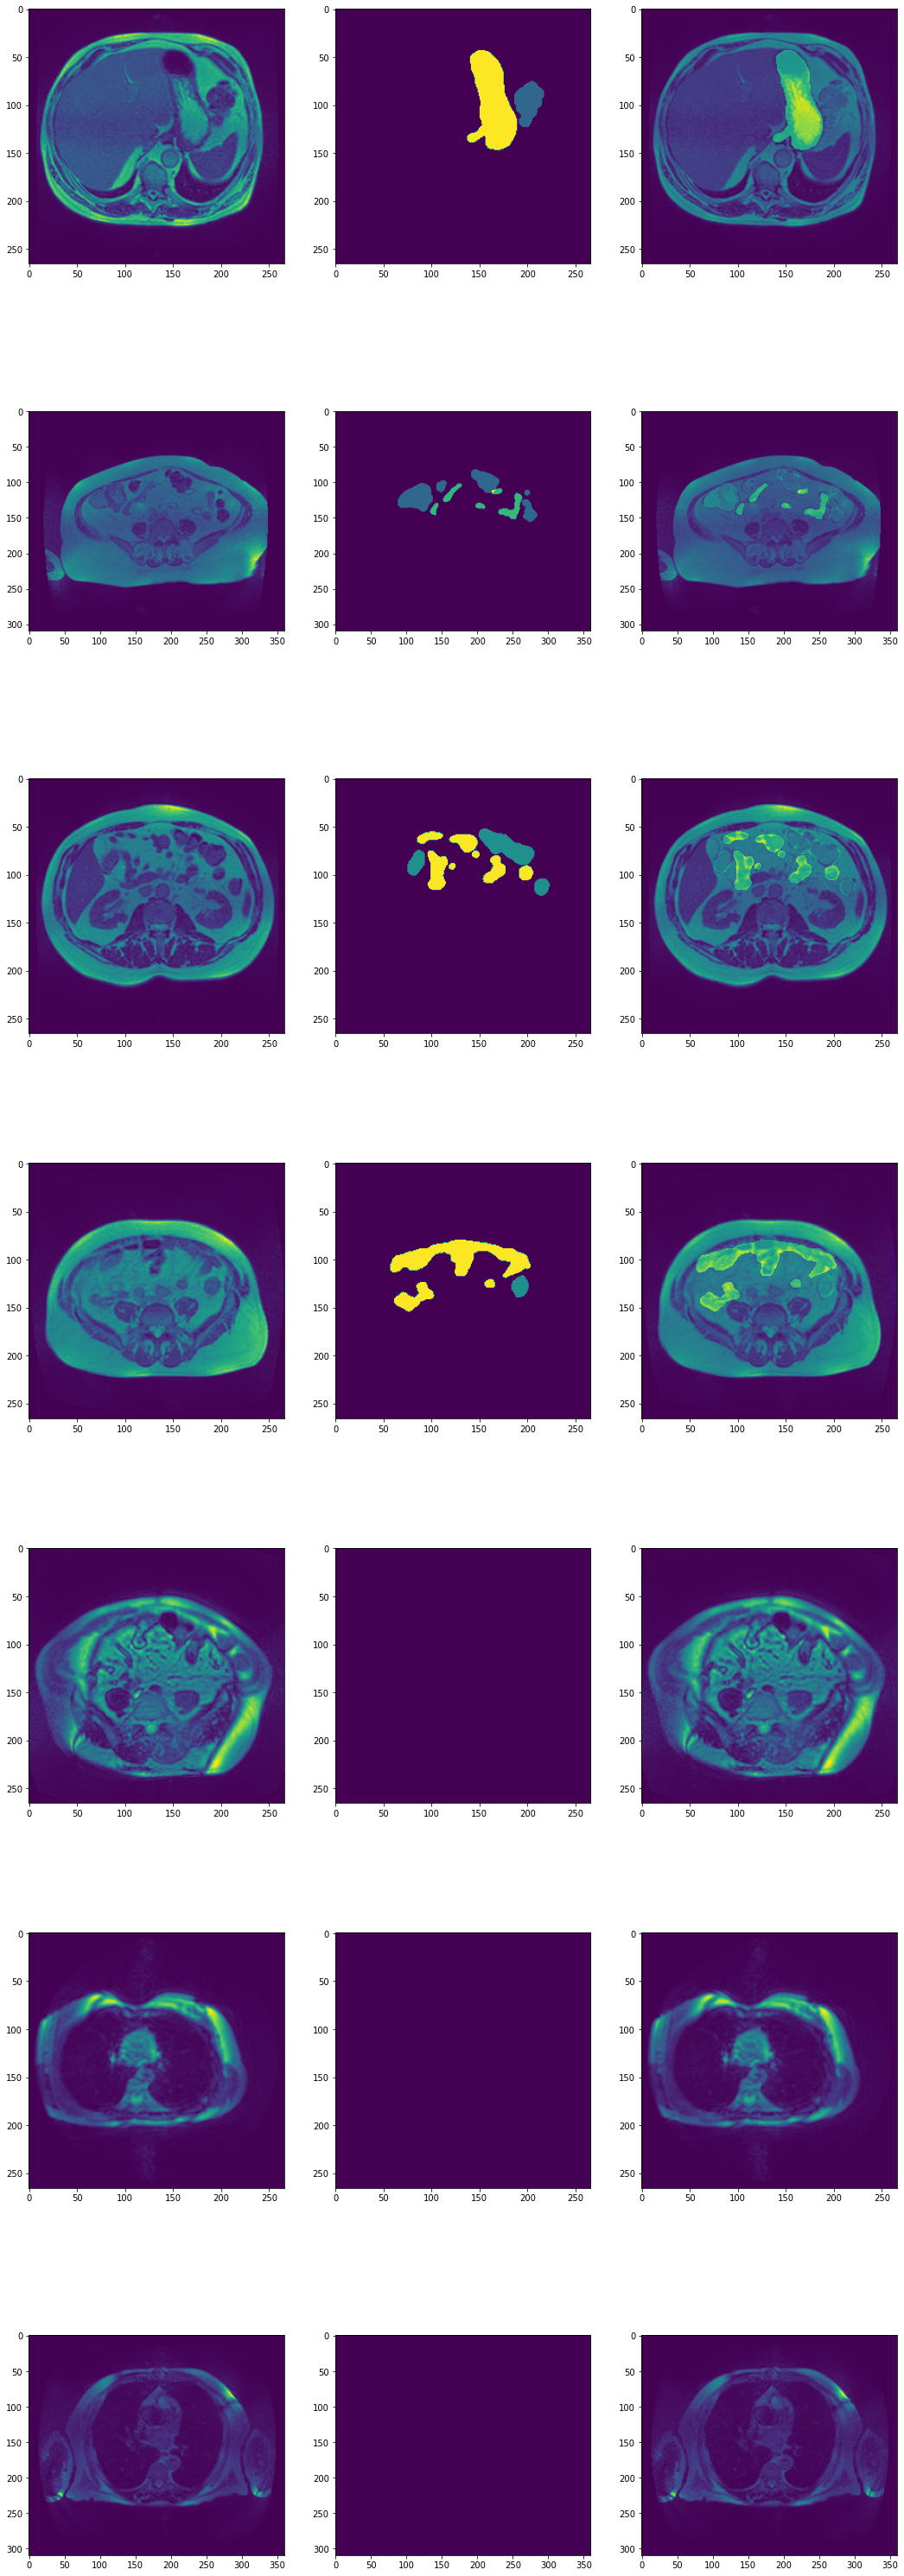

In [ ]:
num = 7
segmentation_df_example = train_df[train_df.large_bowel != ''].sample(num)
labels = ['large_bowel', 'small_bowel', 'stomach']
fig, ax = plt.subplots(num, 3, figsize=(18, 8*num))
for i in range(num):
    record = segmentation_df_example.iloc[i, :]
    
    img = mpimg.imread(record.path, format = 'png')
    ax[i, 0].imshow(img)
    # ax[i, 0].set_title(record.id)
    
    mask = np.zeros(img.shape)
    for j, cl in enumerate(labels):
        mask += rle_decode(record[cl], img.shape)*(j + 1) / 4 * np.max(img)
    ax[i, 1].imshow(mask)
    
    ax[i, 2].imshow(img + mask)

In [9]:
train_ids = train_df[:26971].index
valid_ids = train_df[26971:34677].index
test_ids = train_df[34677:].index

In [10]:
X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]
X_test = train_df[train_df.index.isin(test_ids)]

In [11]:
X_test.head()

,Unnamed: 0,ID,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
34677,34677,case156_day0_slice_0036,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,156,0,36,266,266,0
34678,34678,case156_day0_slice_0037,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,156,0,37,266,266,0
34679,34679,case156_day0_slice_0038,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,156,0,38,266,266,0
34680,34680,case156_day0_slice_0039,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,156,0,39,266,266,0
34681,34681,case156_day0_slice_0040,0,0,0,/content/drive/MyDrive/DL_Project/uw-madison-g...,156,0,40,266,266,0


In [12]:
class DataGenerator(tf.keras.utils.Sequence):

  def grayscaled_img(self, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
    img_size = (128,128)
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32)/255 
    img = np.expand_dims(img,axis=-1)
    return img

  def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
    super().__init__
    self.df=df
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.subset = subset
    self.indexes = np.arange(len(df))
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.df)/self.batch_size))
  
  def on_epoch_end(self):
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    X = np.empty((self.batch_size, 128, 128, 3))
    y = np.empty((self.batch_size, 128, 128, 3))

    indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
    
    for i,img_path in enumerate(self.df['path'].iloc[indexes]):
      w = self.df['width'].iloc[indexes[i]]
      h = self.df['height'].iloc[indexes[i]]
      img = self.grayscaled_img(img_path)
      # print('img shape after _load_grayscaled_img ', img.shape) (128,128,1)
      X[i,] = img

      if self.subset == 'train':
        for k,j in enumerate(['large_bowel', 'small_bowel', 'stomach']):
          rles = str(self.df[j].iloc[indexes[i]])
          mask = rle_decode(rles, shape=(h, w, 1))
          mask = cv2.resize(mask, (128,128))
          y[i,:,:,k] = mask

    if self.subset == 'train':
      return X,y
    else:
      return X 

In [13]:
train_gen = DataGenerator(X_train, shuffle = True)
print(len(train_gen))
val_gen = DataGenerator(X_valid, shuffle = True)
print(len(val_gen))
test_gen = DataGenerator(X_test, batch_size = 1)
print(len(test_gen))

1685
481
3853


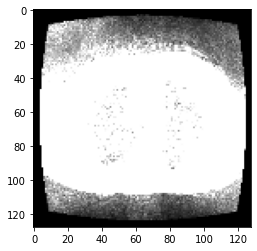

In [14]:
plt.imshow(np.squeeze(train_gen[1000][0][5]))

In [15]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.1 MB/s 


U-Net Model

In [16]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

Metrics

In [17]:
smooth = 0.000001
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f1 = K.flatten(K.round(y_pred))
    intersection = K.sum(y_true_f * y_pred_f1)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f1) + smooth)

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

#combines binary crossentropy with dice loss, very common metric in segmentation. Stability of binary crossentropy remains.
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(
        tf.cast(y_true, tf.float32), y_pred)

Model Definition

In [18]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
model = Unet('inceptionresnetv2',
             input_shape=(128, 128, 3),
             classes=3,
             activation='sigmoid',
             encoder_weights = 'imagenet')
model.compile(optimizer = 'adam',
              loss=bce_dice_loss,
              metrics=[dice_coef])

219055592/219055592 [==============================] - 4s 0us/step


Callbacks

In [19]:
Model_Checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/DL_Project/uw-madison-gi-tract-image-segmentation/weights/Unet_Inceptionresnetv2.h5',
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    mode = 'auto')

reduce_lr = ReduceLROnPlateau(monitor = "val_loss", 
                              factor = 0.1, 
                              patience = 2,
                              verbose = 1)

csv_path = '/content/drive/MyDrive/logs/Unet_Inception_1.csv' 
csv_logger = CSVLogger(csv_path, append=True)

Early_Stopping = EarlyStopping(
    patience = 5,
    min_delta = 0.0001,
    restore_best_weights= True)

callbacks = [Model_Checkpoint, Early_Stopping, reduce_lr, csv_logger]

Training 

In [ ]:
model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=callbacks,
    use_multiprocessing=False,
    workers=4,
    epochs=20)

Epoch 1/20
1685/1685 [==============================] - ETA: 0s - loss: 0.2680 - dice_coef: 0.5488
Epoch 1: val_loss improved from inf to 0.19700, saving model to /content/drive/MyDrive/DL_Project/uw-madison-gi-tract-image-segmentation/weights/Unet_Inceptionresnetv2.h5
1685/1685 [==============================] - 2589s 2s/step - loss: 0.2680 - dice_coef: 0.5488 - val_loss: 0.1970 - val_dice_coef: 0.6526 - lr: 0.0010
Epoch 2/20
1685/1685 [==============================] - ETA: 0s - loss: 0.1451 - dice_coef: 0.7467
Epoch 2: val_loss did not improve from 0.19700
1685/1685 [==============================] - 461s 274ms/step - loss: 0.1451 - dice_coef: 0.7467 - val_loss: 0.2147 - val_dice_coef: 0.6201 - lr: 0.0010
Epoch 3/20
1685/1685 [==============================] - ETA: 0s - loss: 0.1240 - dice_coef: 0.7834
Epoch 3: val_loss improved from 0.19700 to 0.18740, saving model to /content/drive/MyDrive/DL_Project/uw-madison-gi-tract-image-segmentation/weights/Unet_Inceptionresnetv2.h5
1685/168

In [20]:
model.load_weights('/content/drive/MyDrive/DL_Project/uw-madison-gi-tract-image-segmentation/weights/Unet_Inceptionresnetv2.h5')

Visualization - Validation Loss and Dice coefficient

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Dice Coefficient Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model.history['loss'], label='Training Loss')
plt.plot(model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model.history['dice_coef'], label='Dice Coefficient')
plt.plot(model.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Dice Coefficient', fontsize=14)
plt.show()

In [31]:
def plot_masks(img,true,pred):

  plt.figure(figsize=(10,5))
    
  plt.subplot(1,3,1)
  plt.xlabel('Original Image')
  plt.imshow(img, cmap='gray')

  plt.subplot(1,3,2)
  plt.xlabel('Original image with true mask')
  plt.imshow(img)
    # plt.imshow(Test_gen[0][1][i][:,:,-1],cmap='jet',alpha=0.3)
  plt.imshow(true,cmap='jet',alpha=0.3)

  plt.subplot(1,3,3)
  plt.xlabel('Original image with predicted mask')
  plt.imshow(img)
    # plt.imshow(np.squeeze(model.predict(Test_gen[i][0])),cmap='jet',alpha =0.3)
  plt.imshow(pred,cmap='jet',alpha=0.3)

1/1 [==============================] - 0s 75ms/step


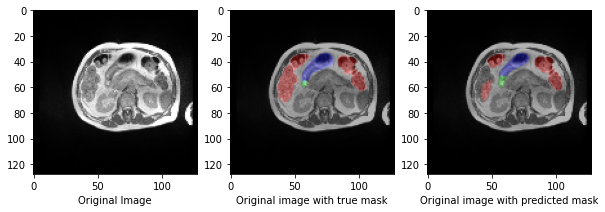

In [35]:
img = np.squeeze(test_gen[200][0])
true = np.squeeze(test_gen[200][1])
pred = np.squeeze(model.predict(test_gen[200][0]))
plot_masks(img,true,pred)